# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
# При необходимости добавляйте новые ячейки для кода или текста

In [3]:
import os
from dotenv import load_dotenv

import pandas as pd
from sqlalchemy import create_engine 
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix

In [4]:
load_dotenv()

db_config = {'user': os.environ.get('DB_USER'), # имя пользователя
             'pwd': os.environ.get('DB_PASSWORD'), # пароль
             'host': os.environ.get('DB_HOST'),
             'port': os.environ.get('DB_PORT'), # порт подключения
             'db': os.environ.get('DB_NAME') # название базы данных
             } 

In [5]:
query = """
SELECT
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    ROUND(
        EXTRACT(DAY FROM (
            p.created_dt_msk - LAG(p.created_dt_msk) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk)))::numeric, 2
    ) AS days_since_prev,
    p.event_id,
    p.service_name,
    e.event_type_main,
    r.region_name,
    c.city_name
FROM afisha.purchases p
INNER JOIN afisha.events e ON p.event_id = e.event_id
JOIN afisha.city c ON e.city_id = c.city_id
JOIN afisha.regions r ON c.region_id = r.region_id
WHERE
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
ORDER BY
    p.user_id ASC,
    p.created_dt_msk ASC
"""

In [6]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 
engine = create_engine(connection_string)

In [7]:
df = pd.read_sql_query(query, con=engine)

In [8]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  region_name            290611 non-null  obje

В нашем датафрейме 290611 строк. Пропуски есть лишь в одном столбце - days_since_prev. Они получаются у тех пользователей,
у которых нет предыдыщей покупки

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [10]:
rev_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [11]:
rev_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [12]:
rev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [13]:
rev_df['data'] = pd.to_datetime(rev_df['data'])
rev_df = rev_df[['data', 'curs']]
rev_df

,data,curs
0,2024-01-10,19.9391
1,2024-01-11,19.7255
2,2024-01-12,19.5839
3,2024-01-13,19.4501
4,2024-01-14,19.4501
...,...,...
352,2024-12-27,19.2705
353,2024-12-28,19.5105
354,2024-12-29,19.4860
355,2024-12-30,19.4860


In [14]:
df = df.merge(rev_df, left_on='order_dt', right_on='data', how='left')
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,data,curs
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск,2024-08-20,18.6972
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск,2024-07-23,18.3419
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск,2024-10-06,19.6475
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск,2024-07-13,18.5010
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк,2024-10-04,19.6648


In [15]:
def func(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    return row['revenue'] * (row['curs'] / 100)
        

df['revenue_rub'] = df.apply(func, axis = 1)

In [16]:
df = df.drop(['data', 'curs'], axis=1)

In [17]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк,1390.41


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [18]:
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
service_name                 0
event_type_main              0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

In [19]:
df.isna().mean()

user_id                  0.000000
device_type_canonical    0.000000
order_id                 0.000000
order_dt                 0.000000
order_ts                 0.000000
currency_code            0.000000
revenue                  0.000000
tickets_count            0.000000
days_since_prev          0.075472
event_id                 0.000000
service_name             0.000000
event_type_main          0.000000
region_name              0.000000
city_name                0.000000
revenue_rub              0.000000
dtype: float64

In [20]:
df['device_type_canonical'].value_counts()

device_type_canonical
mobile     232490
desktop     58121
Name: count, dtype: int64

In [21]:
df['service_name'].value_counts()

service_name
Билеты без проблем        63519
Лови билет!               41124
Билеты в руки             40343
Мой билет                 34839
Облачко                   26642
Лучшие билеты             17774
Весь в билетах            16849
Прачечная                 10273
Край билетов               6207
Тебе билет!                5228
Яблоко                     5039
Дом культуры               4502
За билетом!                2865
Городской дом культуры     2733
Show_ticket                2200
Мир касс                   2167
Быстробилет                2003
Выступления.ру             1616
Восьмёрка                  1118
Crazy ticket!               790
Росбилет                    539
Шоу начинается!             499
Быстрый кассир              381
Радио ticket                376
Телебилет                   321
КарандашРУ                  133
Реестр                      125
Билет по телефону            85
Вперёд!                      80
Дырокол                      74
Кино билет                 

In [22]:
df['event_type_main'].value_counts()

event_type_main
концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: count, dtype: int64

In [23]:
df.duplicated().sum(), df.duplicated(subset=['user_id','order_id','event_id']).sum()

(np.int64(0), np.int64(0))

In [24]:
df[['revenue_rub','tickets_count']].describe()

,revenue_rub,tickets_count
count,290611.000000,290611.000000
mean,555.571987,2.754311
std,875.498172,1.170620
min,-90.760000,1.000000
25%,113.970000,2.000000
50%,351.140000,3.000000
75%,802.050000,4.000000
max,81174.540000,57.000000


<Axes: >

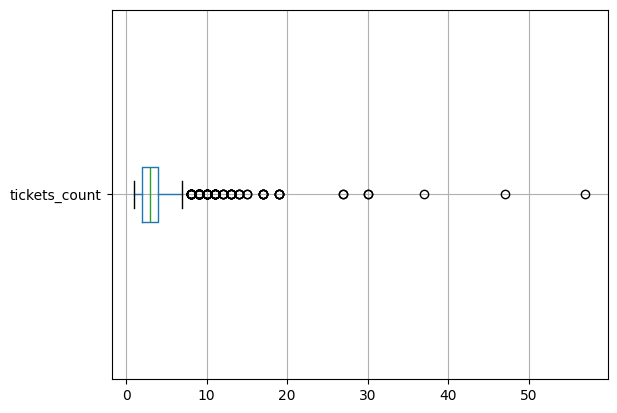

In [25]:
df.boxplot('tickets_count', vert=False)

In [26]:
df.boxplot('revenue_rub', vert=False)

<Axes: >

In [27]:
per_99 = df['revenue_rub'].quantile(0.99)

In [28]:
dff = df[(df['revenue_rub'] <= per_99) & (df['revenue_rub'] > 0)].copy()

In [29]:
dff.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк,1390.41


In [30]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 281879 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                281879 non-null  object        
 1   device_type_canonical  281879 non-null  object        
 2   order_id               281879 non-null  int64         
 3   order_dt               281879 non-null  datetime64[ns]
 4   order_ts               281879 non-null  datetime64[ns]
 5   currency_code          281879 non-null  object        
 6   revenue                281879 non-null  float64       
 7   tickets_count          281879 non-null  int64         
 8   days_since_prev        260491 non-null  float64       
 9   event_id               281879 non-null  int64         
 10  service_name           281879 non-null  object        
 11  event_type_main        281879 non-null  object        
 12  region_name            281879 non-null  object   

In [31]:
dff[['revenue_rub','tickets_count']].describe()

,revenue_rub,tickets_count
count,281879.000000,281879.000000
mean,528.888310,2.744117
std,511.717246,1.157190
min,0.020000,1.000000
25%,122.690000,2.000000
50%,358.290000,3.000000
75%,798.070000,3.000000
max,2628.421739,47.000000


In [32]:
dff.boxplot('revenue_rub', vert=False)

<Axes: >

In [33]:
df.boxplot('tickets_count', vert=False)

<Axes: >

Типы данных оставляем как есть, поскольку объем маленький
Пропуски есть в столбце days_since_prev, но они обусловлены тем, что пользователь сделал всего один заказ
Явных и неявных дубликтов не выявлено

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [34]:
dff = dff.sort_values(by='order_ts').copy()

In [35]:
dff.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,revenue_rub
285281,fd4d47438ebb946,mobile,7565637,2024-06-01,2024-06-01 00:00:42,rub,1083.15,4,0.0,131671,Прачечная,театр,Каменевский регион,Глиногорск,1083.15
285282,fd4d47438ebb946,mobile,7565521,2024-06-01,2024-06-01 00:01:30,rub,812.36,3,0.0,131671,Прачечная,театр,Каменевский регион,Глиногорск,812.36
118843,57ef0a1905ac488,mobile,6670842,2024-06-01,2024-06-01 00:01:58,rub,2091.31,4,NaN,375861,Билеты в руки,театр,Лесодальний край,Родниковец,2091.31
285279,fd4d47438ebb946,mobile,7565550,2024-06-01,2024-06-01 00:03:13,rub,812.36,3,NaN,131671,Прачечная,театр,Каменевский регион,Глиногорск,812.36
264550,e73089d7d016cd8,mobile,5502055,2024-06-01,2024-06-01 00:03:34,rub,181.39,2,0.0,211846,Прачечная,театр,Широковская область,Радужнополье,181.39


In [36]:
profile = dff.sort_values(by='order_ts').groupby('user_id').agg(
    first_order_date=('order_dt', 'first'),
    last_order_date=('order_dt', 'last'),
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_service=('service_name', 'first'),
    first_event_type=('event_type_main', 'first'),
    total_orders=('order_id', 'count'),
    avg_revenue_rub=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean'),
    avg_days_between=('days_since_prev', 'mean')
).reset_index()

In [37]:
profile.head()

,user_id,first_order_date,last_order_date,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets,avg_days_between
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0


In [38]:
profile['is_two'] = profile.apply(lambda row: row['total_orders'] >= 2, axis=1)

In [39]:
profile['is_five'] = profile.apply(lambda row: row['total_orders'] >= 5, axis=1)

In [40]:
profile.head()

,user_id,first_order_date,last_order_date,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets,avg_days_between,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,False,False
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,True,False
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,True,False
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,False,False
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,True,False


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [41]:
profile['user_id'].count()

np.int64(21700)

In [42]:
profile['avg_revenue_rub'].mean()

np.float64(551.8789863444035)

In [43]:
profile['is_two'].mean()

np.float64(0.6166820276497695)

In [44]:
profile['is_five'].mean()

np.float64(0.2886635944700461)

In [45]:
profile[['total_orders','avg_tickets','avg_days_between']].describe()

,total_orders,avg_tickets,avg_days_between
count,21700.000000,21700.000000,13450.000000
mean,12.989816,2.746006,15.918595
std,119.766778,0.914290,22.367653
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000
50%,2.000000,2.750000,8.000000
75%,5.000000,3.090909,20.500000
max,9987.000000,11.000000,148.000000


In [46]:
profile.head()

,user_id,first_order_date,last_order_date,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets,avg_days_between,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,False,False
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,True,False
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,True,False
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,False,False
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,True,False


In [47]:
profile[(profile['total_orders'] <= profile['total_orders'].quantile(0.99))].describe()

,first_order_date,last_order_date,total_orders,avg_revenue_rub,avg_tickets,avg_days_between
count,21483,21483,21483.000000,21483.000000,21483.000000,13233.000000
mean,2024-08-10 23:32:14.981147904,2024-09-18 03:14:07.088395520,6.404506,552.146854,2.746183,16.172063
min,2024-06-01 00:00:00,2024-06-01 00:00:00,1.000000,0.070000,1.000000,0.000000
25%,2024-06-26 00:00:00,2024-08-24 12:00:00,1.000000,217.595000,2.000000,1.333333
50%,2024-08-10 00:00:00,2024-10-03 00:00:00,2.000000,473.098333,2.750000,8.400000
75%,2024-09-24 00:00:00,2024-10-22 00:00:00,5.000000,775.175769,3.111111,21.000000
max,2024-10-31 00:00:00,2024-10-31 00:00:00,150.000000,2628.421739,11.000000,148.000000
std,NaN,NaN,13.982574,433.369922,0.918756,22.461816


In [48]:
profile[(profile['total_orders'] <= profile['total_orders'].quantile(0.95))].describe()

,first_order_date,last_order_date,total_orders,avg_revenue_rub,avg_tickets,avg_days_between
count,20626,20626,20626.000000,20626.000000,20626.000000,12376.000000
mean,2024-08-13 11:55:06.777853184,2024-09-16 11:49:44.233491712,4.030738,553.804187,2.746407,17.113863
min,2024-06-01 00:00:00,2024-06-01 00:00:00,1.000000,0.070000,1.000000,0.000000
25%,2024-07-01 00:00:00,2024-08-22 00:00:00,1.000000,210.088333,2.000000,1.000000
50%,2024-08-14 00:00:00,2024-10-01 00:00:00,2.000000,467.340333,2.750000,9.500000
75%,2024-09-25 00:00:00,2024-10-20 00:00:00,5.000000,787.030000,3.166667,22.333333
max,2024-10-31 00:00:00,2024-10-31 00:00:00,31.000000,2628.421739,11.000000,148.000000
std,NaN,NaN,5.079931,440.727854,0.935564,22.928175


In [49]:
pr_f = profile[(profile['total_orders'] <= profile['total_orders'].quantile(0.95))].copy()

In [50]:
pr_f.describe()

,first_order_date,last_order_date,total_orders,avg_revenue_rub,avg_tickets,avg_days_between
count,20626,20626,20626.000000,20626.000000,20626.000000,12376.000000
mean,2024-08-13 11:55:06.777853184,2024-09-16 11:49:44.233491712,4.030738,553.804187,2.746407,17.113863
min,2024-06-01 00:00:00,2024-06-01 00:00:00,1.000000,0.070000,1.000000,0.000000
25%,2024-07-01 00:00:00,2024-08-22 00:00:00,1.000000,210.088333,2.000000,1.000000
50%,2024-08-14 00:00:00,2024-10-01 00:00:00,2.000000,467.340333,2.750000,9.500000
75%,2024-09-25 00:00:00,2024-10-20 00:00:00,5.000000,787.030000,3.166667,22.333333
max,2024-10-31 00:00:00,2024-10-31 00:00:00,31.000000,2628.421739,11.000000,148.000000
std,NaN,NaN,5.079931,440.727854,0.935564,22.928175


Аномальное число заказов - 9987
Фильтруем по 95 перцентилю, поскольку в данном случае распределению будет более равномерным

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [51]:
pr_f.head()

,user_id,first_order_date,last_order_date,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets,avg_days_between,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,False,False
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,True,False
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,True,False
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,False,False
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,True,False


In [52]:
pr_f.groupby('first_event_type').agg(
    user_count=('user_id', 'count'), 
    user_percentage=('user_id', lambda x: len(x) / pr_f.shape[0])
).sort_values(by = 'user_count', ascending=False)

,user_count,user_percentage
first_event_type,,
концерты,9236,0.447784
другое,4994,0.242122
театр,4081,0.197857
стендап,1078,0.052264
спорт,740,0.035877
выставки,401,0.019441
ёлки,96,0.004654


In [53]:
pr_f.groupby('first_device').agg(
    user_count=('user_id', 'count'), 
    user_percentage=('user_id', lambda x: len(x) / pr_f.shape[0])
).sort_values(by = 'user_count', ascending=False)

,user_count,user_percentage
first_device,,
mobile,17115,0.829778
desktop,3511,0.170222


In [54]:
pr_f.groupby('first_region').agg(
    user_count=('user_id', 'count'), 
    user_percentage=('user_id', lambda x: len(x) / pr_f.shape[0])
).sort_values(by = 'user_count', ascending=False)

,user_count,user_percentage
first_region,,
Каменевский регион,6687,0.324202
Североярская область,3616,0.175313
Широковская область,1194,0.057888
Озернинский край,662,0.032095
Малиновоярский округ,517,0.025065
...,...,...
Залесский край,2,0.000097
Верхозёрский край,1,0.000048
Светолесский край,1,0.000048


In [55]:
pr_f.groupby('first_service').agg(
    user_count=('user_id', 'count'), 
    user_percentage=('user_id', lambda x: len(x) / pr_f.shape[0])
).sort_values(by = 'user_count', ascending=False)

,user_count,user_percentage
first_service,,
Билеты без проблем,4779,0.231698
Мой билет,2878,0.139533
Лови билет!,2697,0.130757
Билеты в руки,2414,0.117037
Облачко,2128,0.103171
Весь в билетах,1238,0.060021
Лучшие билеты,1132,0.054882
Прачечная,552,0.026762
Край билетов,443,0.021478


Данные распределены неравновмерно
По типу лидируют концерты 44%
Большинство заказаов - 80% с мобильных устройств
Регион - Каменевский регион
Лидер билетных операторов - Билеты без проблем

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [56]:
ev = pr_f.groupby('first_event_type').agg({'is_two':'mean'}).sort_values(by = 'is_two', ascending=False)
ev

,is_two
first_event_type,
выставки,0.630923
театр,0.618966
концерты,0.602425
стендап,0.594620
другое,0.575691
ёлки,0.562500
спорт,0.533784


In [57]:
ev.plot(kind='bar', grid=True,
        title='Доля пользователей, совершивших два и более заказа по мероприятию', xlabel='Мероприятие', ylabel='Доля')

<Axes: title={'center': 'Доля пользователей, совершивших два и более заказа по мероприятию'}, xlabel='Мероприятие', ylabel='Доля'>

In [58]:
dv = pr_f.groupby('first_device').agg({'is_two':'mean'}).sort_values(by = 'is_two', ascending=False)
dv

,is_two
first_device,
desktop,0.618058
mobile,0.592346


In [59]:
dv.plot(kind='bar', grid=True,
        title='Доля пользователей, совершивших два и более заказа по устройству', xlabel='Устройство', ylabel='Доля')

<Axes: title={'center': 'Доля пользователей, совершивших два и более заказа по устройству'}, xlabel='Устройство', ylabel='Доля'>

In [60]:
rv = pr_f.groupby('first_region').agg({'is_two':'mean'}).sort_values(by = 'is_two', ascending=False)
rv

,is_two
first_region,
Верхозёрский край,1.000000
Озернопольская область,0.888889
Радужнопольский край,0.761905
Тихолесский край,0.700000
Лесостепной край,0.678571
...,...
Крутоводский регион,0.333333
Островогорский округ,0.000000
Светолесский край,0.000000


In [61]:
rv.iloc[:10].plot(kind='bar', grid=True,
        title='Доля пользователей, совершивших два и более заказа по региону', xlabel='Регион', ylabel='Доля')

<Axes: title={'center': 'Доля пользователей, совершивших два и более заказа по региону'}, xlabel='Регион', ylabel='Доля'>

In [62]:
ov = pr_f.groupby('first_service').agg({'is_two':'mean'}).sort_values(by = 'is_two', ascending=False)
ov

,is_two
first_service,
Зе Бест!,1.000000
Быстрый кассир,0.836364
Билет по телефону,0.833333
Реестр,0.777778
Восьмёрка,0.674699
Crazy ticket!,0.674419
Росбилет,0.650000
Show_ticket,0.642857
Край билетов,0.641084


In [63]:
ov.iloc[:10].plot(kind='bar', grid=True,
        title='Доля пользователей, совершивших два и более заказа по оператору', xlabel='Оператор', ylabel='Доля')

<Axes: title={'center': 'Доля пользователей, совершивших два и более заказа по оператору'}, xlabel='Оператор', ylabel='Доля'>

Распределение по типу мероприятия и типу устройства относительно равномерно
Для исследования региона были оставлены 10 популряных значений, в них распределение тоже равномерно за исключением первого значения равного 1
Аналогичная ситуация и с операторами, распределение в целом равномерно, за исключением первого значения


---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [64]:
pr_f.groupby('first_event_type').agg({'is_two':'mean'}).sort_values(by = 'is_two', ascending=False)

,is_two
first_event_type,
выставки,0.630923
театр,0.618966
концерты,0.602425
стендап,0.594620
другое,0.575691
ёлки,0.562500
спорт,0.533784


Гипотеза не подтверждается, пользователи совершившие первый заказал на спортивные мероприятия совершают потворный заказ реже,
чем пользователи на концерты

In [65]:
pr_f.groupby('first_region').agg({'is_two':'mean'}).sort_values(by = 'first_region', ascending=True)

,is_two
first_region,
Белоярская область,0.588235
Берестовский округ,0.636364
Берёзовская область,0.633663
Боровлянский край,0.505155
Верховинская область,0.500000
...,...
Шанырский регион,0.666667
Широковская область,0.633166
Яблоневская область,0.581454


Гипотеза подтверждается, в регионах, где больше всего пользователей посещают мероприятия, 
выше доля повторных заказов, чем в менее активных регионах

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


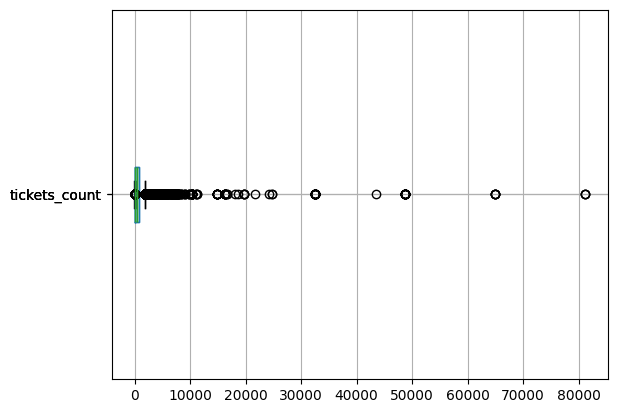

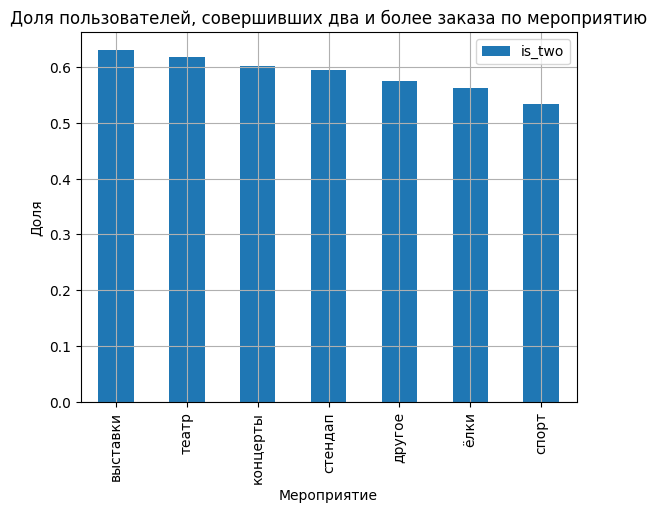

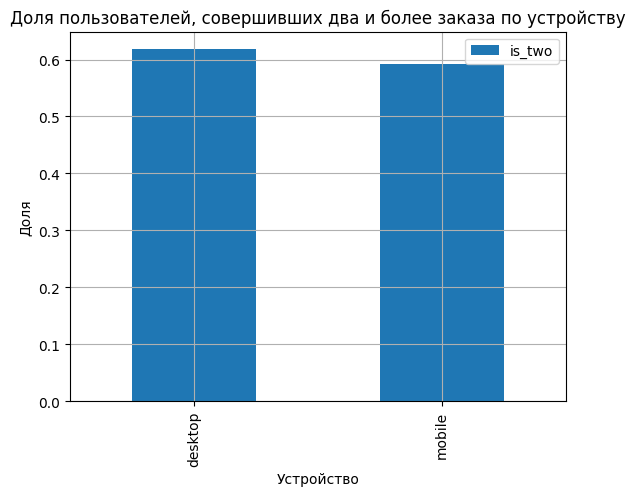

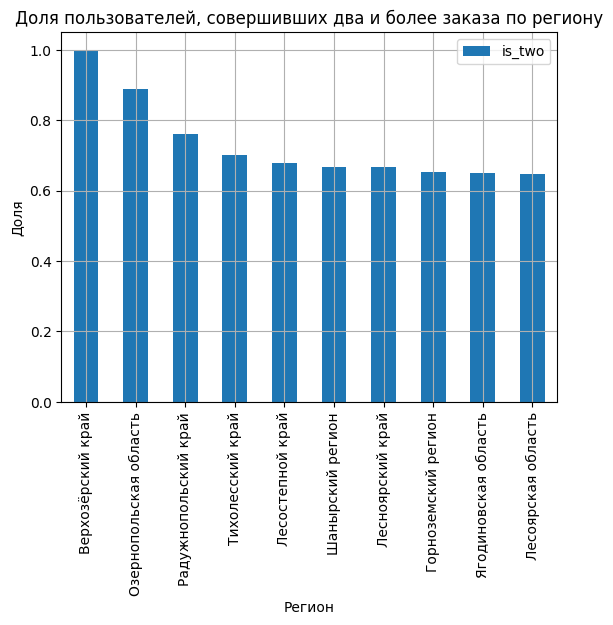

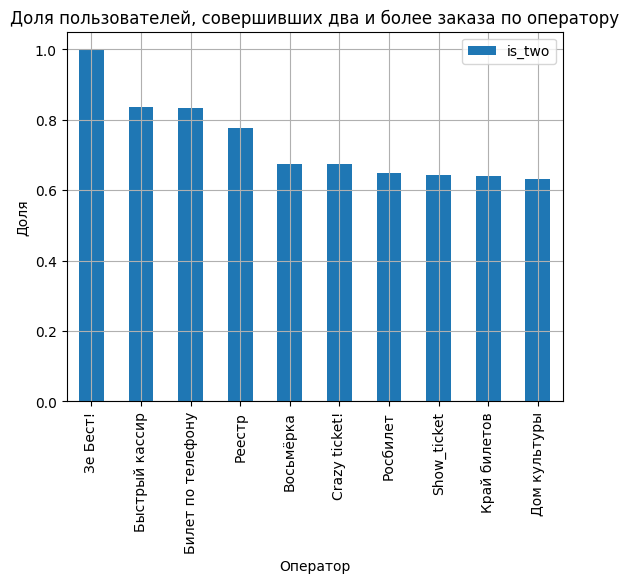

<Figure size 1000x600 with 0 Axes>

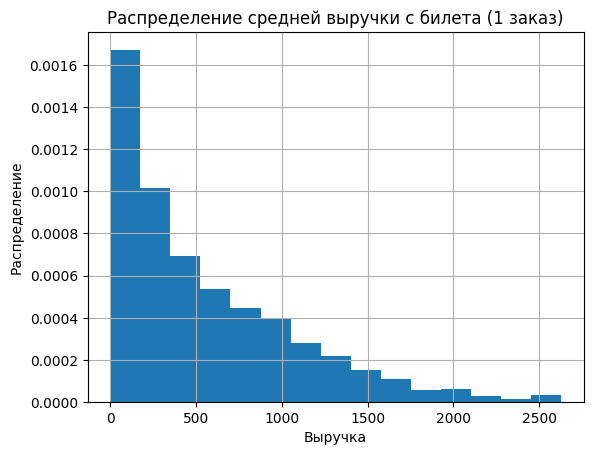

In [66]:
plt.figure(figsize=(10,6))
pr_f[pr_f['is_two'] == False].hist(column='avg_revenue_rub', bins=15, alpha=1, density=True)

plt.title('Распределение средней выручки с билета (1 заказ)')
plt.xlabel('Выручка')
plt.ylabel('Распределение')
plt.show()

Основная выручка сосредоточена в диапазоне до 500р

<Figure size 1000x600 with 0 Axes>

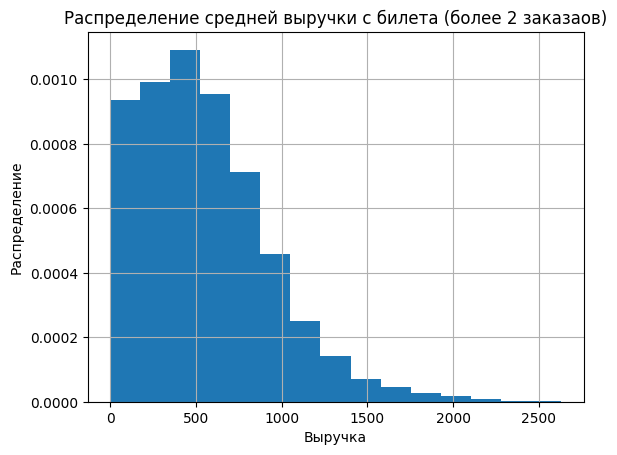

In [67]:
plt.figure(figsize=(10,6))
pr_f[pr_f['is_two'] == True].hist(column='avg_revenue_rub', bins=15, alpha=1, density=True)

plt.title('Распределение средней выручки с билета (более 2 заказаов)')
plt.xlabel('Выручка')
plt.ylabel('Распределение')
plt.show()

Основные значения сосредоточены около 500р

Между группами имеется небольшое отлчие. У пользователей покупающих больше 2 билетов выручка несколько больше

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


<Figure size 1000x600 with 0 Axes>

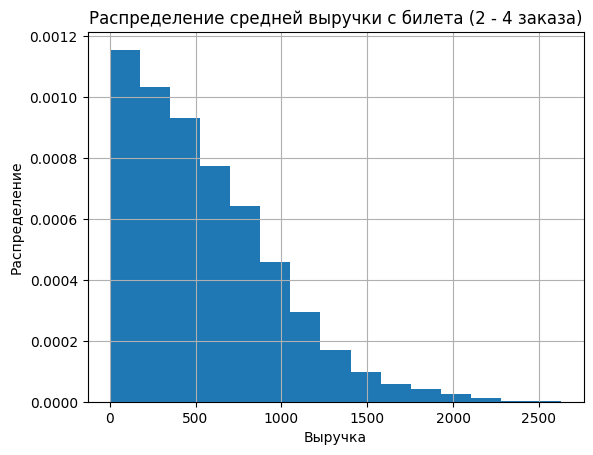

In [68]:
plt.figure(figsize=(10,6))
pr_f[(pr_f['is_two'] == True) & (pr_f['is_five'] == False)].hist(column='avg_revenue_rub', bins=15, alpha=1, density=True)

plt.title('Распределение средней выручки с билета (2 - 4 заказа)')
plt.xlabel('Выручка')
plt.ylabel('Распределение')
plt.show()

<Figure size 1000x600 with 0 Axes>

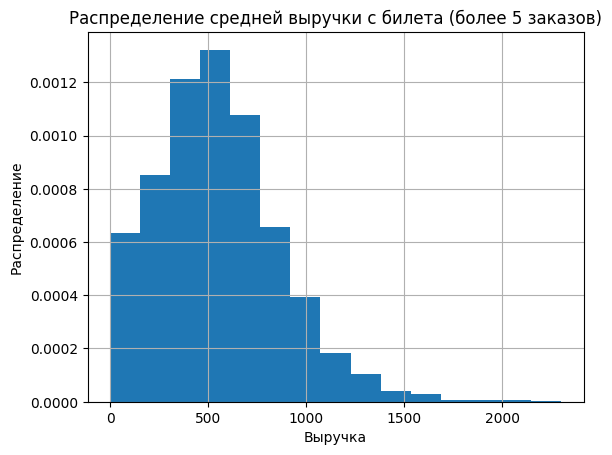

In [69]:
plt.figure(figsize=(10,6))
pr_f[pr_f['is_five'] == True].hist(column='avg_revenue_rub', bins=15, alpha=1, density=True)

plt.title('Распределение средней выручки с билета (более 5 заказов)')
plt.xlabel('Выручка')
plt.ylabel('Распределение')
plt.show()

Немного большая средняя выручка наблюдается у группы пользователей, совершивших более 5 заказов

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

<Figure size 1000x600 with 0 Axes>

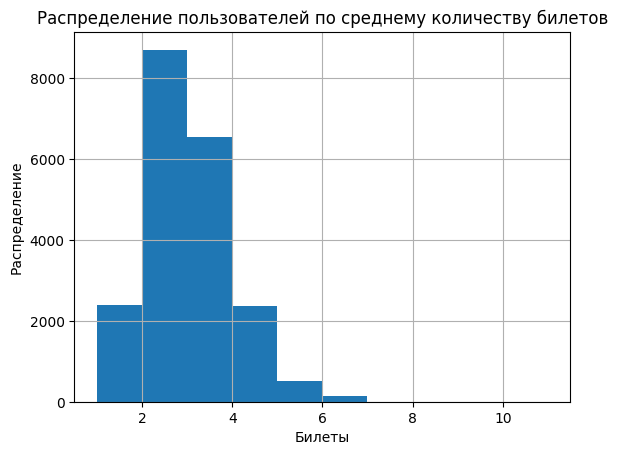

In [70]:
plt.figure(figsize=(10,6))
pr_f.hist(column='avg_tickets', bins=10)

plt.title('Распределение пользователей по среднему количеству билетов')
plt.xlabel('Билеты')
plt.ylabel('Распределение')
plt.show()

<Figure size 1000x600 with 0 Axes>

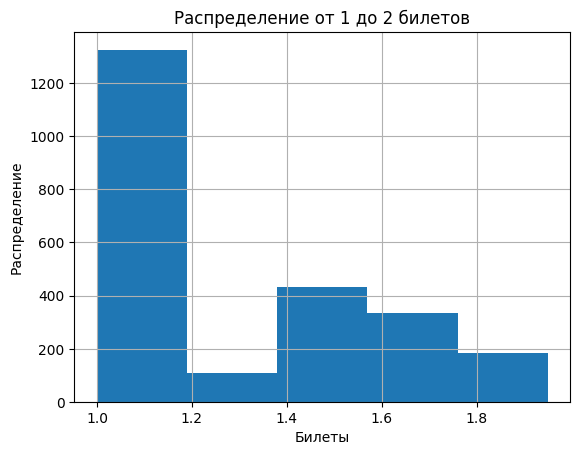

In [71]:
plt.figure(figsize=(10,6))
pr_f.query('avg_tickets >= 1 and avg_tickets < 2').hist(column='avg_tickets', bins=5)

plt.title('Распределение от 1 до 2 билетов')
plt.xlabel('Билеты')
plt.ylabel('Распределение')
plt.show()

In [72]:
pr_f.query('avg_tickets >= 1 and avg_tickets < 2').shape[0], pr_f.query('avg_tickets >= 1 and avg_tickets < 2').shape[0] / pr_f.shape[0]

(2387, 0.11572772229225249)

<Figure size 1000x600 with 0 Axes>

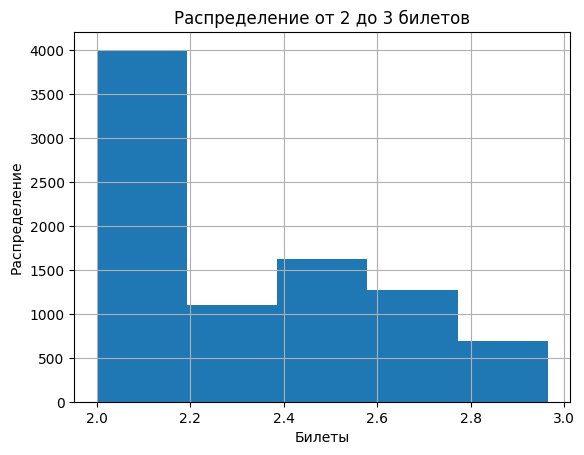

In [73]:
plt.figure(figsize=(10,6))
pr_f.query('avg_tickets >= 2 and avg_tickets < 3').hist(column='avg_tickets', bins=5)

plt.title('Распределение от 2 до 3 билетов')
plt.xlabel('Билеты')
plt.ylabel('Распределение')
plt.show()

In [74]:
pr_f.query('avg_tickets >= 2 and avg_tickets < 3').shape[0], pr_f.query('avg_tickets >= 2 and avg_tickets < 3').shape[0] / pr_f.shape[0]

(8688, 0.42121594104528265)

<Figure size 1000x600 with 0 Axes>

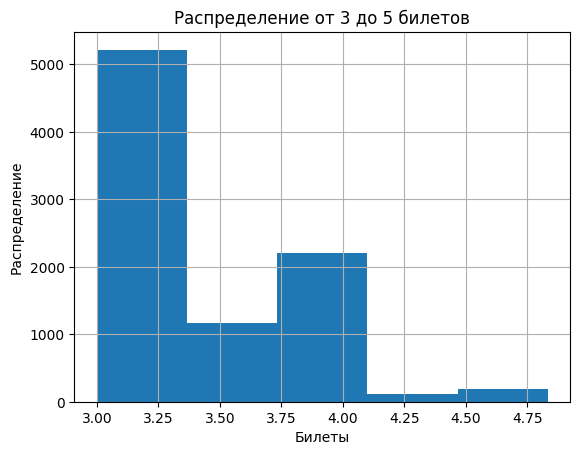

In [75]:
plt.figure(figsize=(10,6))
pr_f.query('avg_tickets >= 3 and avg_tickets < 5').hist(column='avg_tickets', bins=5)

plt.title('Распределение от 3 до 5 билетов')
plt.xlabel('Билеты')
plt.ylabel('Распределение')
plt.show()

In [76]:
pr_f.query('avg_tickets >= 3 and avg_tickets < 5').shape[0], pr_f.query('avg_tickets >= 3 and avg_tickets < 5').shape[0] / pr_f.shape[0]

(8894, 0.4312033355958499)

<Figure size 1000x600 with 0 Axes>

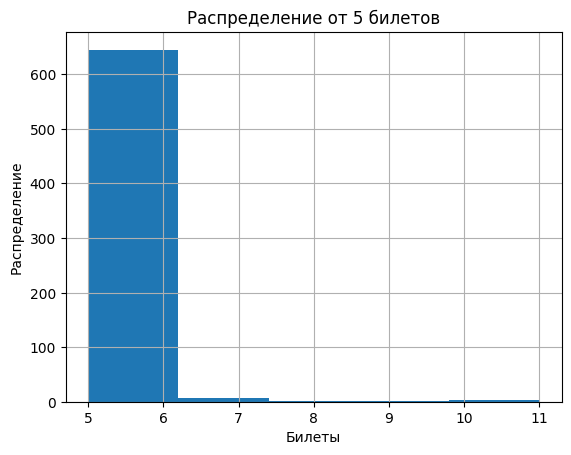

In [77]:
plt.figure(figsize=(10,6))
pr_f.query('avg_tickets >= 5').hist(column='avg_tickets', bins=5)

plt.title('Распределение от 5 билетов')
plt.xlabel('Билеты')
plt.ylabel('Распределение')
plt.show()

In [78]:
pr_f.query('avg_tickets >= 5').shape[0], pr_f.query('avg_tickets >= 5').shape[0] / pr_f.shape[0]

(657, 0.031853001066614955)

Чаще всего у пользователей примерно от 2 до 4 билетов

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [79]:
pr_f['day'] = pr_f['first_order_date'].dt.day_name()

In [80]:
pr_f.head()

,user_id,first_order_date,last_order_date,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets,avg_days_between,is_two,is_five,day
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,False,False,Tuesday
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,True,False,Tuesday
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,True,False,Saturday
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,False,False,Thursday
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,True,False,Sunday


In [81]:
pr_f['day'].value_counts()

day
Friday       3138
Saturday     3095
Thursday     3012
Tuesday      3011
Wednesday    2952
Monday       2797
Sunday       2621
Name: count, dtype: int64

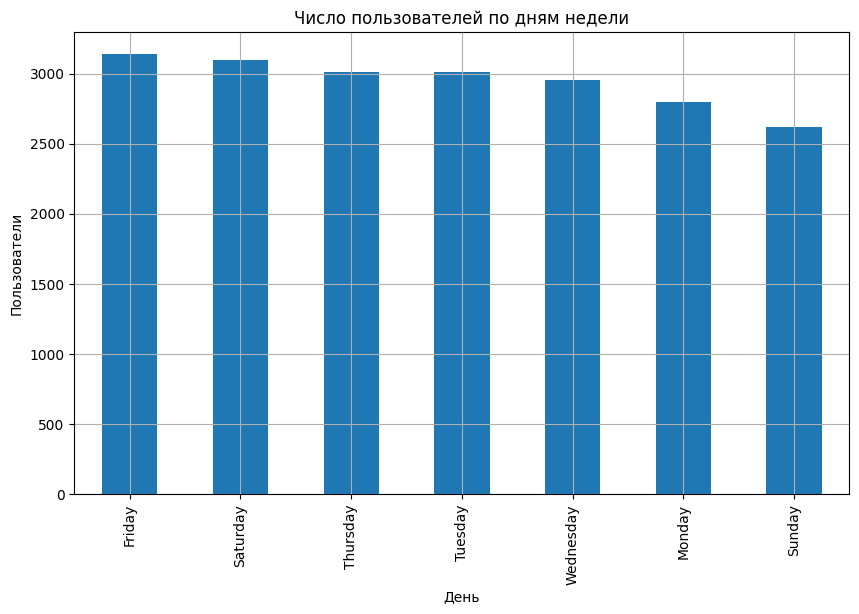

In [82]:
plt.figure(figsize=(10,6))
pr_f['day'].value_counts().plot(kind='bar', grid=True)
plt.title('Число пользователей по дням недели')
plt.xlabel('День')
plt.ylabel('Пользователи')
plt.show()

In [83]:
pr_f['day'].value_counts(normalize=True)

day
Friday       0.152138
Saturday     0.150053
Thursday     0.146029
Tuesday      0.145981
Wednesday    0.143120
Monday       0.135606
Sunday       0.127073
Name: proportion, dtype: float64

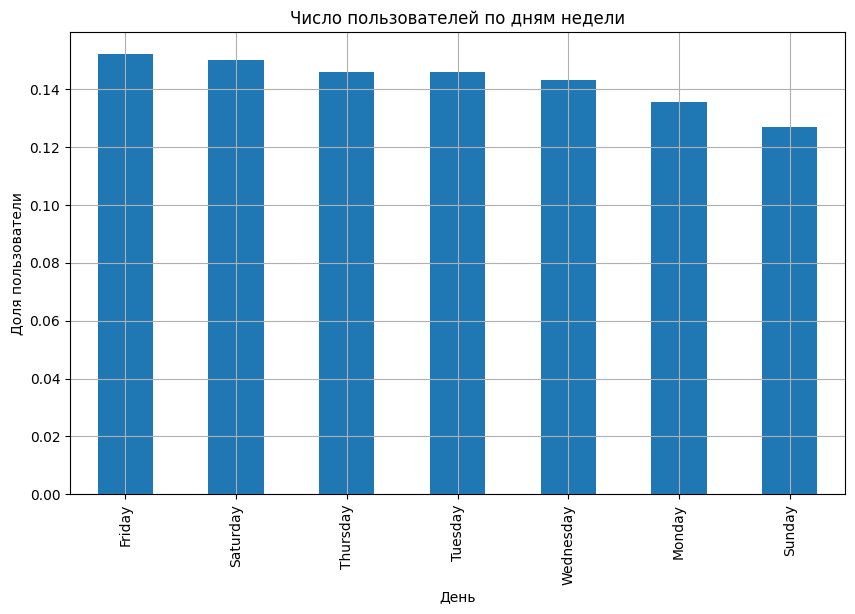

In [84]:
plt.figure(figsize=(10,6))
pr_f['day'].value_counts(normalize=True).plot(kind='bar', grid=True)
plt.title('Число пользователей по дням недели')
plt.xlabel('День')
plt.ylabel('Доля пользователи')
plt.show()

В целом распределение в течении недели равномерно. Однако можно заметить небольшой спад в понедельник и воскресенье.
Возможно это связано с рабочим графиком покупателей

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [85]:
pr_f.query('is_two == True and is_five == False')['avg_days_between'].mean()

np.float64(21.238866254565888)

In [86]:
pr_f.query('is_five == True')['avg_days_between'].mean()

np.float64(11.097093993424586)

Средний интервал между заказами у пользователей, совершивших более 5 заказов в два раза больше чем у пользователей с 2-4 заказами 

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [87]:
matrix = pr_f[['first_order_date','last_order_date','first_device','first_region',
     'first_service','first_event_type','total_orders','avg_revenue_rub','avg_tickets','avg_days_between']].phik_matrix()

matrix = matrix.loc[matrix.index != 'total_orders'][['total_orders']].sort_values(by='total_orders', ascending=False)
matrix

interval columns not set, guessing: ['total_orders', 'avg_revenue_rub', 'avg_tickets', 'avg_days_between']


,total_orders
avg_days_between,0.487383
last_order_date,0.400239
first_order_date,0.396702
avg_tickets,0.296606
avg_revenue_rub,0.265381
first_device,0.043218
first_service,0.041105
first_event_type,0.035094
first_region,0.000000


In [88]:
sns.heatmap(data=matrix,vmin=0,vmax=1, annot=True, fmt=".2f", cmap="coolwarm")

plt.title("Матрица корреляции количества заказов")

Text(0.5, 1.0, 'Матрица корреляции количества заказов')

Из анализа корреляции количества заказов можно сделать вывод о том, что больше всего влияют "временные признаки" - 
first_order_date,last_order_date, avg_days_between

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

Для формирования датафрейма для анализа был выполнен SQL запрос из базы данных. В нем проверены типы данных и пропуски. В результате предварительной обработки были приведены валюту к единой (руб). Пропуски были лишь в столбце days_since_prev, обусловленные условиями задания. Данные были исследованы на аномальные занчения - найдены выбросы в выручке. Эти значения отфильтрованы по 99 перцентелю. Затем был создан датафрейм с профилем пользователя. В него добавлены два бинарных признках о количество заказов (больше 2 и больше 5). В профиле содержится 21700 пользователь. Также были найдены выбросы в количестве заказов, которые отфильтрованы по 95 перцентелю (9987 значений). Был проведено исселдование распределения по типу меропрития, устройтсву, региону и оператору -  по этим данным распределение примерно равномерное. Было изучено распределение по выручке - основыне значения находятся в диапазоне 500р. Пользователи были разбиты на сегменты и исседованы статистические показатели. Был проведен корреляционный анализ количества заказов - наибольшее влияние оказывают признаки с датой и временем. Сегмент пользователей с 5+ заказами является наиболее стабильным и приносит наибольшую выручку, поэтому стоит сконцентрироваться на удержании таких клиентов.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**